# Soldering pen design

In [176]:
#Initialization of iPython, some helper functions.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')
from sympy import *
from IPython.display import display, Math, Latex
init_printing(use_latex="mathjax")

_Omega=u'\u03A9'

def readCsvData(fileName):
    return np.genfromtxt(fileName, delimiter=';')

def plotData(data, timebase=1, xlabel="", ylabel="",names=[]):
    fig=plt.figure(figsize=[10,5])
    l = np.size(data,0)
    time = np.linspace(0,l-1,l)*timebase
    if np.ndim(data)>1: # If more than one vector to plot
        count = np.size(data,1)
        for i in range(count):
            plt.plot(time, data[:,i], label=names[i])
    else:
        plt.plot(time, data, label=names[0])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.plot()
    
def plotCsv(fileName, timebase=1, xlabel="", ylabel="",names=[]):
    data = readCsvData(fileName)
    plotData(data, timebase, xlabel, ylabel,names)

## Basic assumptions

### Block diagram
![Block diagram](img/soldering_pen_block_diagram.png)

### Power supply
Power requirements are:

In [80]:
# Tip rated power [W]
Ptip = 40
# Supply voltage [minimum, typical, maximum] [V]
Vsupply = [6, 12, 20]

Rated tip power (40 W) is defined for typical supply voltage (12 V). For lower supply voltage maximum power is lower than nominal. For minimum power supply:

In [81]:
Ptip_min=(Vsupply[0]**2)/(Vsupply[1]**2)*40
print(Ptip_min,"W")

10.0 W


Device withstands power supply voltage in range of -30..+30 V but is non-operational outside Vsupply range.

### Temperature
Operational range of ambient temperature is:

In [82]:
Tambient = [0, 40] # [minimum, maximum] *C

Working range of tip temperature is:

In [83]:
Ttip = [200, 350] # [minimum, maximum] *C

## Power supply circuits

## Heater driver
Heater driver is selected to be BTS5012SDA. Lets calculate maximum current of the driver.

In [94]:
# Nominal resistance of the tip heater
Rtip = Vsupply[1]**2/Ptip; print("Rtip = %1.2f %s" % (Rtip, _Omega))
# Nominal heater current at nominal voltage
Itip_nominal = Vsupply[1]/Rtip; print("Itip_nominal = %1.2f A" % Itip_nominal)
# Safety factor
k_safety = 1.1
# Minimum tip current - at minimum voltage, including safety factor
Itip_min = Vsupply[0]/Rtip/k_safety; print("Itip_min = %1.2f A" % Itip_min)
# Peak current - at maximum voltage, including safety factor
Itip_max = Vsupply[2]/Rtip*k_safety; print("Itip_max = %1.2f A" % Itip_max)

Rtip = 3.60 Ω
Itip_nominal = 3.33 A
Itip_min = 1.52 A
Itip_max = 6.11 A


BTS5012SDA has built-in diagnosis and current sense circuits. It can be used to detect that proper heater is connected.

Value of current sense ratio ($k_{ilis}$) can be read from dataqsheet graph (actual points read using http://arohatgi.info/WebPlotDigitizer/). For simplification, only two points are used.
![](img/BTS5012SDA_kilis_300px.png)

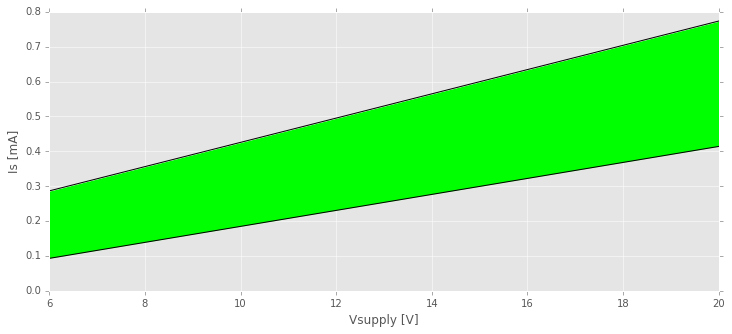

In [136]:
# Supply voltage for use as x axis in plots
Vs = np.array([Vsupply[0], Vsupply[2]])
# Minimum k_ilis valuses for supply voltage range
k_ilis_min = np.array([6400, 7900])
# Maximum k_ilis valuses for supply voltage range
k_ilis_max = np.array([16300, 12200])
# Minimum nominal current sense, mA
Is_min = Vs/Rtip/k_safety/k_ilis_max*1000
# Maximum nominal current sense, mA
Is_max = Vs/Rtip*k_safety/k_ilis_min*1000
# Plot graph
plt.rcParams['figure.figsize'] = 12, 5
plt.figure
plt.plot(Vs, Is_min,"k")
plt.plot(Vs, Is_max,"k")
plt.fill_between(Vs, Is_min, Is_max, facecolor='lime')
plt.ylim(0); plt.xlabel("Vsupply [V]"); plt.ylabel("Is [mA]"); plt.show()

To calculate ADC readings from current sense circuit sense resistor and ADC errors must be taken into account. 

[  34.  171.] [ 242.  627.]


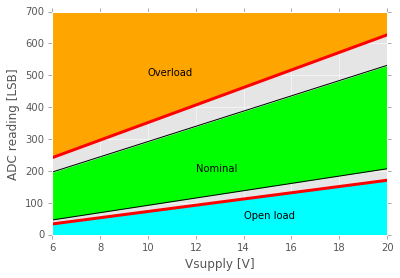

In [206]:
# Sense resistor nominal value.
Rs = 470
# Sense resistor tolerance, including thermal coefficient.
Rs_tol = 0.06
# uC power supply voltage range, V
Vcc = 3.3; Vcc_min = 2.97; Vcc_max = 3.63
# Input voltage, min and max
Vs_min = Is_min * Rs / 1000 / (1+Rs_tol)
Vs_max = Is_max * Rs / 1000 * (1+Rs_tol)
# ADC readings, min and max
ADCs_min = Vs_min / Vcc_max * 4096
ADCs_max = Vs_max / Vcc_min * 4096
# Limits are chosen to provide some additional safety
ADC_lim_min = np.floor(ADCs_min * 0.85 - 5)
ADC_lim_max = np.ceil(ADCs_max * 1.15 + 15)
# print limits
print(ADC_lim_min, ADC_lim_max)
# Plot graph
plt.figure
plt.plot(Vs, ADCs_min,"k")
plt.plot(Vs, ADCs_max,"k")
plt.plot(Vs, ADC_lim_min, "r", linewidth=3)
plt.plot(Vs, ADC_lim_max, "r", linewidth=3)
plt.fill_between(Vs, ADCs_min, ADCs_max, facecolor='lime')
plt.text(12, 200, "Nominal")
plt.fill_between(Vs, 0, ADC_lim_min, facecolor='aqua')
plt.text(14, 50, "Open load")
plt.fill_between(Vs, ADC_lim_max, 700, facecolor='orange')
plt.text(10, 500, "Overload")
plt.ylim(0,700); plt.xlabel("Vsupply [V]"); plt.ylabel("ADC reading [LSB]"); plt.show()

Vsupply is measured by Vin_sense ADC input. Current sense thresholds related to Vin_sense readings are calculated below. Power supply sense resistors tolerances are neglected. At the end, limits are represented as $ADC_{lim}=a*ADC_{Vin}+b$.

In [207]:
# ADC readings for Vin_sense input, only nominal values
ADCvin = np.floor(Vs * 10 / (100 + 10) / Vcc * 4095)
display(ADCvin)
# Coefficient for integer multiply
int_coef = 65536
# Calculate coefficients for lim = a*Vin+b
a_min = int((ADC_lim_min[1] - ADC_lim_min[0])/(ADCvin[1] - ADCvin[0])*int_coef)
b_min = int(ADC_lim_min[1] - a_min/int_coef * ADCvin[1])
a_max = int((ADC_lim_max[1] - ADC_lim_max[0])/(ADCvin[1] - ADCvin[0])*int_coef)
b_max = int(ADC_lim_max[1] - a_max/int_coef * ADCvin[1])
# Display as en equations
display(Math(r"ADClim_{min}=\frac{%d}{%d}*ADC_{Vin}+%d" %(a_min, int_coef, b_min)))
display(Math(r"ADClim_{max}=\frac{%d}{%d}*ADC_{Vin}+%d" %(a_max, int_coef, b_max)))
# Check
display(Math(r"ADC\ limits\ assumed\begin{pmatrix} %d & %d \\ %d & %d \end{pmatrix}" %
            (ADC_lim_max[0], ADC_lim_max[1], ADC_lim_min[0], ADC_lim_min[1]) +
            r"calculated\begin{pmatrix} %d & %d \\ %d & %d \end{pmatrix}" %
            (ADCvin[0] * a_max / int_coef + b_max, ADCvin[1] * a_max / int_coef + b_max,
            ADCvin[0] * a_min / int_coef + b_min, ADCvin[1] * a_min / int_coef + b_min)))

array([  676.,  2256.])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [177]:
display(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx'))

<IPython.core.display.Math object>

## Sensor amplifier

## Microcontroller

## Magnetometer

Permanent neodymium magnet is mounted in soldering iron stand. On board MEMS magnetometer is used to sense its' proximity. If magnet is detected, soldering iron goes to sleep mode after programmed time.
MAG3110 has full scale range of $\pm 1000 \mu T$. Zero flux offset is typically $\pm 100 \mu T$. It's large, compared to typical geomagnetic field strength of $25\ldots60 \mu T$. Zero offset calibration is desirable.

### Magnitude calculation
For calculating magnitude of magnetic field flux density from X, Y, Z readings, following formula should be used:

In [85]:
x, y, z, a, b, c, m_real, m_appr, z_1 = symbols("x y z a b c m_real m_appr z_1")
m_real_ = Equality(m_real, sqrt(x**2 + y**2 + z**2)); display(m_real_)

            ______________
           ╱  2    2    2 
m_real = ╲╱  x  + y  + z  

To minimize calculations, approximation will be used. Derivative of alpha max plus beta min algorithm will be used.

In [86]:
m_appr_ = Equality(m_appr, a*abs(x) + b*abs(y) + c*abs(z)); display(m_appr_)

m_appr = a⋅│x│ + b⋅│y│ + c⋅│z│

Simple values for a, b, c are selected:

In [87]:
m_appr_ = m_appr_.subs(a,1).subs(b, 1/2).subs(c, 1/4); display(m_appr_)

m_appr = │x│ + 0.5⋅│y│ + 0.25⋅│z│

Let's calculate error of this formula.

To simplify calculations and visualization, three parameters are simplified to two. For every $\frac{y}{x}=const$ and $\frac{z}{x}=const$ error will be the same. $x=const=1$ is selected for this calculation. x>=y>=z, so maximum value of y is 1. As y>=z another variable is substituted instead of z:

In [88]:
Equality(z_1,z/y)

     z
z₁ = ─
     y

In [89]:
m_real_ = Equality(m_real, sqrt(1 + y**2 + (z_1*y)**2)); display(m_real_)
m_appr_ = m_appr_.subs(x,1).subs(z,z_1*y); display(m_appr_)

            _________________
           ╱  2   2    2     
m_real = ╲╱  y ⋅z₁  + y  + 1 

m_appr = 0.5⋅│y│ + 0.25⋅│y⋅z₁│ + 1

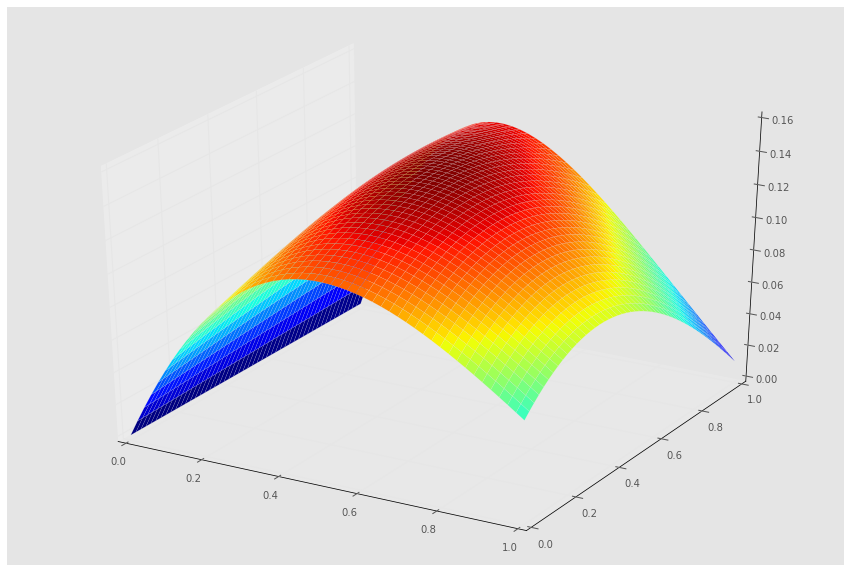

In [90]:
plt.rcParams['figure.figsize'] = 15, 10
plotting.plot3d(m_appr_.rhs/m_real_.rhs-1,(y,0,1),(z_1,0,1));plt.show()

~15% error is perfectly acceptable. It's even better, because error is always >=0, so relative ripples are +-7.5%.